In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

args = {
    'batch_size': 20,
    'num_workers': 4,
    'num_classes': 10,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 30
}

In [ ]:
from ucimlrepo import fetch_ucirepo 

bike_sharing = fetch_ucirepo(id=275) 
  
X = bike_sharing.data.features 
y = bike_sharing.data.targets 

df = pd.concat([X, y], axis=1)
print(df.head())

       dteday  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
0  2011-01-01       1   0     1   0        0        6           0           1   
1  2011-01-01       1   0     1   1        0        6           0           1   
2  2011-01-01       1   0     1   2        0        6           0           1   
3  2011-01-01       1   0     1   3        0        6           0           1   
4  2011-01-01       1   0     1   4        0        6           0           1   

   temp   atemp   hum  windspeed  cnt  
0  0.24  0.2879  0.81        0.0   16  
1  0.22  0.2727  0.80        0.0   40  
2  0.22  0.2727  0.80        0.0   32  
3  0.24  0.2879  0.75        0.0   13  
4  0.24  0.2879  0.75        0.0    1  


In [9]:
torch.manual_seed(1)
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))
df_train   = df.iloc[indices[:train_size]]
df_test    = df.iloc[indices[train_size:]]

df_train.to_csv('bike_train.csv', index=False)
df_test.to_csv('bike_test.csv', index=False)

In [10]:
class Bicicletas(DataLoader):
    def __init__(self, csv_path):
        self.dados = pd.read_csv(csv_path).to_numpy()
    
    def __getitem__(self, idx):
        sample = self.dados[idx][2:14]
        label  = self.dados[idx][-1:]
        
        sample = torch.from_numpy(sample.astype(np.float32))
        label = torch.from_numpy(label.astype(np.float32))
        
        return sample, label

    def __len__(self):
        return len(self.dados)

In [11]:
train_set = Bicicletas('bike_train.csv')
test_set = Bicicletas('bike_test.csv')

dado, rotulo = train_set[0]

print(rotulo)
print(dado)

tensor([373.])
tensor([1.0000e+00, 1.1000e+01, 1.9000e+01, 0.0000e+00, 4.0000e+00, 1.0000e+00,
        1.0000e+00, 3.8000e-01, 3.9390e-01, 2.7000e-01, 3.5820e-01, 3.7300e+02])


In [12]:
train_loader = DataLoader(train_set, batch_size=args['batch_size'], shuffle=True, num_workers=args['num_workers'])
test_loader = DataLoader(test_set, batch_size=args['batch_size'], shuffle=True, num_workers=args['num_workers'])

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(MLP, self).__init__()
        
        self.features = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU())

        self.out = nn.Linear(hidden_size, out_size)

    def forward(self, X):
        
        feature = self.features(X)
        output = self.out(feature)
        
        return output
    
input_size  = len(train_set[0][0])
hidden_size = 128
out_size    = 1

net = MLP(input_size, hidden_size, out_size)

In [15]:
criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [27]:
def train(train_loader, net, epoch):
    net.train()

    epoch_loss = []

    for dado, rotulo in train_loader:
        optimizer.zero_grad()

        pred = net(dado)
        loss = criterion(pred, rotulo)

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

    epoch_loss = np.array(epoch_loss)
    
    print("Época %d, Loss: %.4f, +- %.4f" % (epoch, epoch_loss.mean(), epoch_loss.std()))
    
    return epoch_loss.mean()


In [28]:
def test(test_loader, net, epoch):
    epoch_loss = []

    net.eval()
    with torch.no_grad():
        for dado, rotulo in test_loader:
            optimizer.zero_grad()

            pred = net(dado)
            loss = criterion(pred, rotulo)

            epoch_loss.append(loss.item())

        epoch_loss = np.array(epoch_loss)
        print("Época %d, Loss: %.4f, +- %.4f" % (epoch, epoch_loss.mean(), epoch_loss.std()))
        
        return epoch_loss.mean()


In [19]:
for epoch in range(args['num_epochs']):
    train(train_loader, net, epoch)
    test(test_loader, net, epoch)

Época 0, Loss: 28.8655, +- 56.0395
Época 0, Loss: 0.1180, +- 0.0208
Época 1, Loss: 0.2054, +- 0.1341
Época 1, Loss: 0.0565, +- 0.0101
Época 2, Loss: 0.1840, +- 0.1267
Época 2, Loss: 0.3396, +- 0.0739
Época 3, Loss: 0.2157, +- 0.1546
Época 3, Loss: 0.2613, +- 0.0455
Época 4, Loss: 0.2016, +- 0.1518
Época 4, Loss: 0.0724, +- 0.0223
Época 5, Loss: 0.1768, +- 0.1397
Época 5, Loss: 0.1040, +- 0.0128
Época 6, Loss: 0.2044, +- 0.1636
Época 6, Loss: 0.1680, +- 0.0282
Época 7, Loss: 0.1637, +- 0.1257
Época 7, Loss: 0.1656, +- 0.0233
Época 8, Loss: 0.1842, +- 0.1631
Época 8, Loss: 0.0585, +- 0.0138
Época 9, Loss: 0.1886, +- 0.1682
Época 9, Loss: 0.1979, +- 0.0432
Época 10, Loss: 0.1927, +- 0.1555
Época 10, Loss: 0.2428, +- 0.0509
Época 11, Loss: 0.1710, +- 0.1294
Época 11, Loss: 0.1244, +- 0.0209
Época 12, Loss: 0.1754, +- 0.1446
Época 12, Loss: 0.1487, +- 0.0294
Época 13, Loss: 0.1758, +- 0.1415
Época 13, Loss: 0.3940, +- 0.0807
Época 14, Loss: 0.1678, +- 0.1306
Época 14, Loss: 0.0938, +- 0.017

In [23]:
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

Xtest, ytest = next(iter(test_loader))

net.eval()
with torch.no_grad():
    ypred = net(Xtest)

data = torch.cat((ytest, ypred), dim=1)

df_results = pd.DataFrame(data.cpu().numpy(), columns=['ytest', 'ypred'])

df_results.head(20)


,ytest,ypred
0,352.0,351.772278
1,156.0,155.864349
2,12.0,12.005209
3,2.0,1.983937
4,391.0,390.779419
5,391.0,390.765259
6,84.0,83.937614
7,487.0,486.705261
8,176.0,175.885513
9,157.0,156.908920


In [29]:
train_losses, test_losses = [], []
for epoch in range(args['num_epochs']):
    train_losses.append(train(train_loader, net, epoch))
    test_losses.append(test(test_loader, net, epoch))

Época 0, Loss: 0.1611, +- 0.1268
Época 0, Loss: 0.0951, +- 0.0000
Época 1, Loss: 0.1790, +- 0.1486
Época 1, Loss: 0.1025, +- 0.0000
Época 2, Loss: 0.1210, +- 0.0999
Época 2, Loss: 0.1887, +- 0.0000
Época 3, Loss: 0.1295, +- 0.1164
Época 3, Loss: 0.0559, +- 0.0000
Época 4, Loss: 0.1713, +- 0.1316
Época 4, Loss: 0.0198, +- 0.0000
Época 5, Loss: 0.1546, +- 0.1203
Época 5, Loss: 0.1354, +- 0.0000
Época 6, Loss: 0.1487, +- 0.1299
Época 6, Loss: 0.0538, +- 0.0000
Época 7, Loss: 0.1571, +- 0.1340
Época 7, Loss: 0.2514, +- 0.0000
Época 8, Loss: 0.1340, +- 0.1022
Época 8, Loss: 0.1758, +- 0.0000
Época 9, Loss: 0.1496, +- 0.1158
Época 9, Loss: 0.0389, +- 0.0000
Época 10, Loss: 0.1522, +- 0.1206
Época 10, Loss: 0.1561, +- 0.0000
Época 11, Loss: 0.1458, +- 0.1333
Época 11, Loss: 0.0692, +- 0.0000
Época 12, Loss: 0.1630, +- 0.1348
Época 12, Loss: 0.1479, +- 0.0000
Época 13, Loss: 0.1684, +- 0.1373
Época 13, Loss: 0.0270, +- 0.0000
Época 14, Loss: 0.1396, +- 0.1081
Época 14, Loss: 0.0438, +- 0.0000


[np.float64(0.16114045379030378), np.float64(0.17896933827198636), np.float64(0.12097463145953785), np.float64(0.12951109772574843), np.float64(0.1713367098080658), np.float64(0.15462734135959683), np.float64(0.14870073835649153), np.float64(0.15705129616470986), np.float64(0.13404049500608925), np.float64(0.14958084052583823), np.float64(0.15216971101204532), np.float64(0.14577536770388827), np.float64(0.16303218381436563), np.float64(0.1684203830898215), np.float64(0.13960199667563683), np.float64(0.15755206899283902), np.float64(0.15026047886764074), np.float64(0.13735286938227265), np.float64(0.14730777121657485), np.float64(0.21251567209142141), np.float64(0.17495862766698903), np.float64(0.1711083179321033), np.float64(0.1402126926508593), np.float64(0.1539705801044655), np.float64(0.13052285968689997), np.float64(0.14134585289632495), np.float64(0.1679677616339177), np.float64(0.1489542299438664), np.float64(0.1394913542798945), np.float64(0.14697659601211205)]


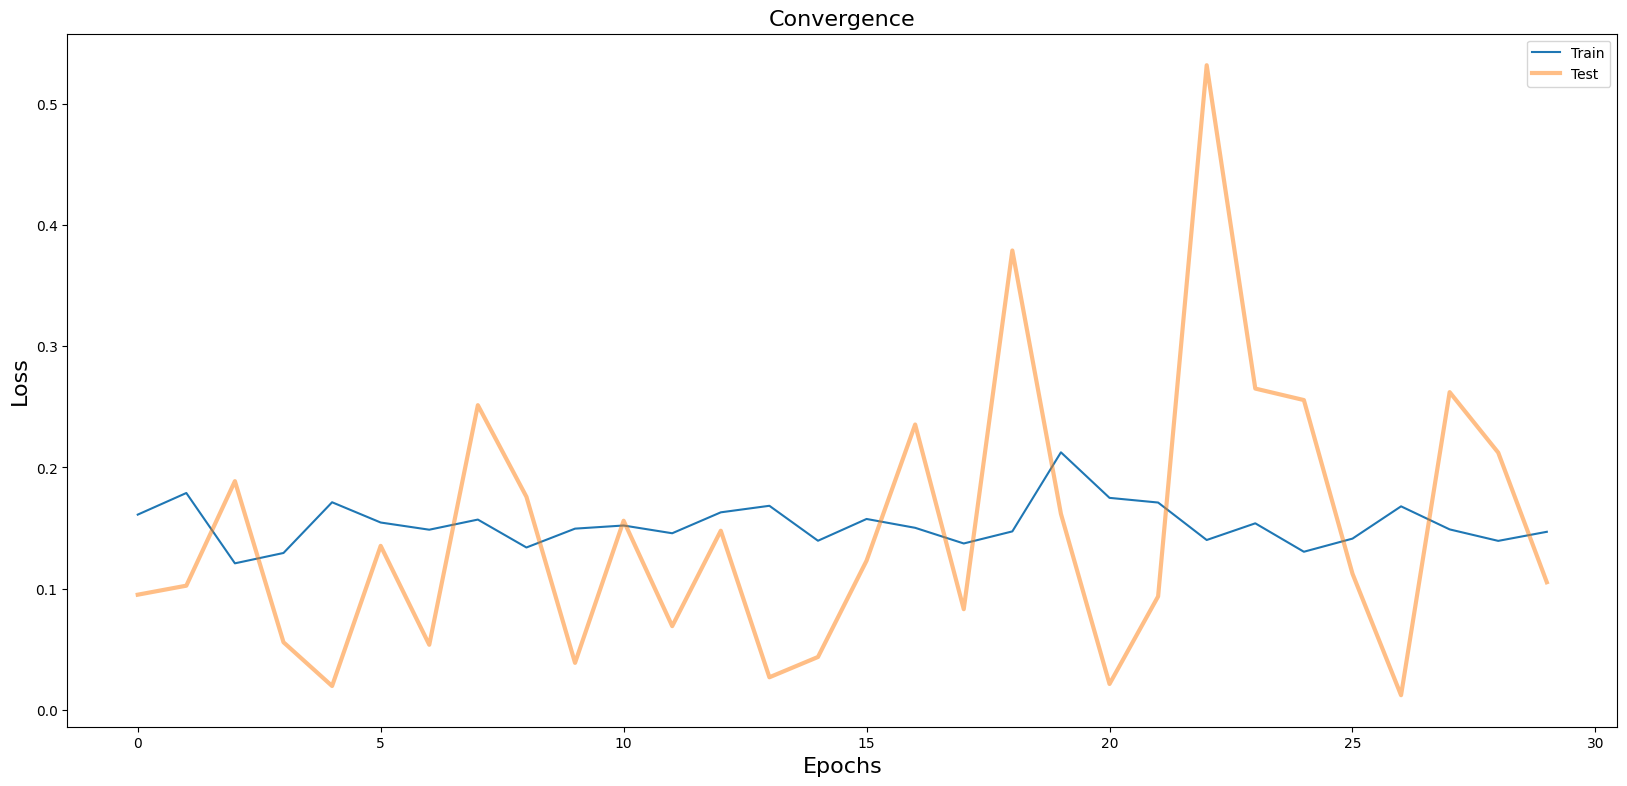

In [30]:
print(train_losses)
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()